In [64]:

#standard data wrangling packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import requests

import os
import os.path


#### ExoFOP contains a list of TESS Objects of Interest (TOI). These index highly promising exoplanet candidates gained from TESS light curve data that will require other methods to determine whether the object is a confirmed exoplanet or not.

In [3]:
exofop_TOI_url = "https://exofop.ipac.caltech.edu/tess/download_toi.php?sort=toi&output=csv"

In [4]:
TOI_data = pd.read_csv(exofop_TOI_url, delimiter = ',')

In [5]:
TOI_data.columns

Index(['TIC ID', 'TOI', 'Previous CTOI', 'Master', 'SG1A', 'SG1B', 'SG2',
       'SG3', 'SG4', 'SG5', 'ACWG', 'TESS Disposition', 'TFOPWG Disposition',
       'TESS Mag', 'TESS Mag err', 'Planet Name', 'Pipeline Signal ID',
       'Source', 'RA', 'Dec', 'PM RA (mas/yr)', 'PM RA err (mas/yr)',
       'PM Dec (mas/yr)', 'PM Dec err (mas/yr)', 'Epoch (BJD)',
       'Epoch (BJD) err', 'Period (days)', 'Period (days) err',
       'Duration (hours)', 'Duration (hours) err', 'Depth (mmag)',
       'Depth (mmag) err', 'Depth (ppm)', 'Depth (ppm) err',
       'Planet Radius (R_Earth)', 'Planet Radius (R_Earth) err',
       'Planet Insolation (Earth Flux)', 'Planet Equil Temp (K)', 'Planet SNR',
       'Stellar Distance (pc)', 'Stellar Distance (pc) err',
       'Stellar Eff Temp (K)', 'Stellar Eff Temp (K) err',
       'Stellar log(g) (cm/s^2)', 'Stellar log(g) (cm/s^2) err',
       'Stellar Radius (R_Sun)', 'Stellar Radius (R_Sun) err',
       'Stellar Metallicity', ' Stellar Metallicity err',

In [6]:
TOI_data.shape

(2542, 54)

In [7]:
TOI_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 54 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   TIC ID                          2542 non-null   int64  
 1   TOI                             2542 non-null   float64
 2   Previous CTOI                   207 non-null    object 
 3   Master                          2542 non-null   int64  
 4   SG1A                            2542 non-null   int64  
 5   SG1B                            2542 non-null   int64  
 6   SG2                             2542 non-null   int64  
 7   SG3                             2542 non-null   int64  
 8   SG4                             2542 non-null   int64  
 9   SG5                             2542 non-null   int64  
 10  ACWG                            2542 non-null   int64  
 11  TESS Disposition                2542 non-null   object 
 12  TFOPWG Disposition              25

In [8]:
TOI_data.loc[0, 'Sectors']

'27'

There is a lot of stuff going on here. TIC ID is an important identifier. It stands for Tess Input Catalog ID. The TESS Input Catalog is essentially a list of all possible stellar targets for TESS to target. The TOIs are a tiny fraction of the entire TIC but the TIC ID could be potentially useful for directly extracting light curve data from the star that the TOI was identified from. There are some other important data attributes here. The TFOPWG Disposition labels are:

In [9]:
TOI_data['TFOPWG Disposition'].unique()

array(['KP', 'CP', 'PC', 'APC', 'FA', 'FP', nan], dtype=object)

KP corresponds to a Known Planet.
CP correponds to a Confirmed Planet.
FP corresponds to a False Positive.

False positives occur routinely due to the limited resolution and large field of view of the TESS telescopes. Thus many other astrophysical objects can cause periodically modulate the light from a given star. One example is the scenario where you are actually looking at a binary star system which happens to be an eclipsing binary system from our point of view. Many of these false positives have certain time series signatures that distinguish them from a real planet transit.

In [10]:
{'Planets': sum(TOI_data['TFOPWG Disposition'] == ('KP' or 'CP')), 'False Positives': sum(TOI_data['TFOPWG Disposition'] == 'FP')} 

{'Planets': 285, 'False Positives': 467}

Maybe these many instances are enough of a dataset for doing a binary classification on whether a given light curve corresponds to a likely planet or another type of astrophysical phenomenon. If not, we can join confirmed planet and false positive data from other missions like the Kepler2 (K2 mission). It might also be interesting to make this a multiclass problem by also including light curves that have no transits in them.

####  MAST (Mulkowski Archive for Space Telescopes) holds the data from many astronomical satellite missions in a form that is pretty well structured. We'll be accessing their data through their web API:

In [11]:
base_url = "https://exo.mast.stsci.edu/api/v0.1/"

# data validation is a summary dataset for a TOI that has the best light curve/transition crossing event data and metadata in it.
data_validation_url = base_url + "dvdata/tess/" 

In [12]:
# in order to query a particular TOI we need to reference it with its TIC number. 
TICID0, class0 = (TOI_data.loc[2, 'TIC ID'], TOI_data.loc[2, 'TFOPWG Disposition'])
print(TICID0, class0)
# Known planet. We'll use this TIC ID for a request to the EXOMAST data validation API in order to get a list of time series:
query_url = data_validation_url + str(TICID0) +'/tces'


req = requests.get(query_url)
sectortcelist = req.json()['TCE']

336732616 KP


In [13]:
sectortcelist

['s0001-s0001:TCE_1']

We'll always just pick the first light curve scan because that should be enough for a given candidate:

In [14]:
def TESSget_sector_tce(sectortcelist):
    sectortce = sectortcelist[0].split(':')
    sector = sectortce[0]
    TCE_num = sectortce[1].split('_')[1]
    
    return sector, TCE_num
    

In [317]:
sectors, TCEnumber = TESSget_sector_tce(sectortcelist)

Now we feed this into the API:

In [336]:
lightcurve_request = data_validation_url + str(TICID0) + '/table/?tce=' + TCEnumber + '&sector='+sectors

In [367]:
lcrequest = requests.get(lightcurve_request)
lightcurve_json= lcrequest.json()


In [368]:
lightcurvedf = pd.DataFrame(lightcurve_json['data'])

In [369]:
lightcurvedf.shape

(20076, 15)

In [372]:
lightcurvedf.columns

Index(['TICID', 'EXTNAME', 'TIME', 'TIMECORR', 'CADENCENO', 'PHASE', 'LC_INIT',
       'LC_INIT_ERR', 'LC_WHITE', 'LC_DETREND', 'MODEL_INIT', 'MODEL_WHITE',
       'DATE_OBS', 'TESSDatetime', 'SECTORS'],
      dtype='object')

#### The detrended light curve vs time is what we are really interested in. The below plots the relative flux vs. Barycentric Time Julian Day. This time is often used in astrophysics and is the time as would be measured by a non-rotating observer at rest with the solar system's center of mass but far enough away from the bulk of the solar system to not experience time dilation from solar system gravity (i.e. clocks move slower near the sun than at the rim of the solar system).

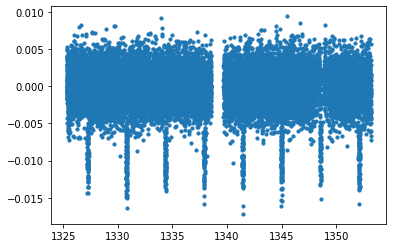

In [387]:
plt.scatter(lightcurvedf['TIME'], lightcurvedf['LC_DETREND'], marker = 'o', s = 10 )

#### This is the light curve for the given TOI which has been classified as a planet. Note that there are NaNs in the series -- the most obvious being the one in the middle of the LC. These sorts of gaps are due to periods during which TESS is firing thrusters. There are also a whole bunch of single gaps in the data. There are many ways in which we could impute this data. For gaps involving a few time points, simple linear interpolation might be fine. But the larger gaps corresponding to TESS thruster fires might need to be imputed by sampling the power spectrum of the non-TCE part of the signal and filling in data sampled from that frequency distribution. In any case, we'll likely need to process these time series a bit more to make them amenable for any classification algorithms, but for now let's write a function that extracts light curves and tucks the messy API requests under the hood.

Also will be helpful to save this data in local csv files with any additional data from the EXOFOP as a header

In [94]:
def get_detrended_LC(TIC_ID):
    # setting up API request path based on TIC ID
    base_url = "https://exo.mast.stsci.edu/api/v0.1/"
    data_validation_url = base_url + "dvdata/tess/" 
    query_url = query_url = data_validation_url + str(TIC_ID) +'/tces'
    
    #now we get the list of sectors/TCEs that were used to identify the light curve as a TOI
    req = requests.get(query_url)
    sectortcelist = req.json()['TCE']
    
    #we will just take the first TCE we can get from the list (in form 's0001-s0001:TCE_1')
    sectortce = sectortcelist[0].split(':')
    sector = sectortce[0] # extracts sector range for scan
    TCE_num = sectortce[1].split('_')[1] #this just parses the TCE string to get the TCE number.
    
    lightcurve_request = data_validation_url + str(TIC_ID) + '/table/?tce=' + TCE_num + '&sector='+sector
    
    lcrequest = requests.get(lightcurve_request)
    lightcurve_json= lcrequest.json()
    
    LC_detrended = pd.DataFrame(lightcurve_json['data'], columns = ['TIME', 'LC_DETREND'])
    
    save_path_directory = os.path.dirname(os.getcwd()) + '\data\\raw\\'
    filename = 'TC'+str(TIC_ID) + TCE_num + 'sector='+sector + ".csv"
    save_path = save_path_directory + filename
    
    LC_detrended.to_csv(save_path)
    return LC_detrended
    
    

In [95]:
h = get_detrended_LC(336732616)

In [36]:
h.shape

(20076, 2)

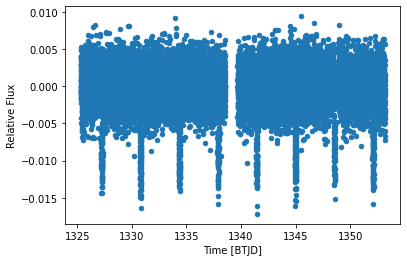

In [96]:
ax = h.plot(x = 'TIME', y = 'LC_DETREND', kind = 'scatter')
ax.set_xlabel('Time [BTJD]')
ax.set_ylabel('Relative Flux')
plt.show()


OK so far so good. Now, let's join this with data from the ExoFOP table so we can put label identifiers as headers. We can later reform and preprocess as required for the classication modeling that we want to do.